In [1]:
import os
import math
import scvi
import scgen
import rpy2
import scib
import json
import torch
import anndata
import logging
import warnings
import scanorama
import anndata2ri
import matplotlib
import pandas as pd
import scanpy as sc
import numpy as np
import seaborn as sb
import scrublet as scr
import doubletdetection
import decoupler as dc
from anndata import AnnData
from tabnanny import verbose
import matplotlib.pyplot as plt
from gsva_prep import prep_gsva
from os import PathLike, fspath
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from matplotlib.pyplot import rcParams
from statsmodels.stats.multitest import multipletests
from sklearn.model_selection import train_test_split
from pytorch_lightning.loggers import TensorBoardLogger
from rpy2.robjects.conversion import localconverter

Global seed set to 0
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/phenograph/cluster.py:13: DeprecationWarning: Please use `spmatrix` from the `scipy.sparse` name

In [2]:
def get_sys_dpi(width, height, diag):
    '''
    obtain dpi of system
    
    w: width in pixels (if unsure, go vist `whatismyscreenresolution.net`)
    h: height in pixels
    d: diagonal in inches
    '''
    w_inches = (diag**2/ (1 + height**2/width**2))**0.5
    return round(width/w_inches)

In [3]:
# # Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# # Automatically convert rpy2 outputs to pandas dataframes
# pandas2ri.activate()
# anndata2ri.activate()
# %load_ext rpy2.ipython

warnings.filterwarnings("ignore", category=PendingDeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

rcParams['figure.dpi'] = get_sys_dpi(1512, 982, 14.125)
#rcParams['figure.figsize']=(4,4) #rescale figures

sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()



/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:351: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/rpy2/robjects/numpy2ri.py:226: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/rpy2/robjects/conversion.py:28: DeprecationWarning: The use of converter in module rpy2.robjects.conversion is deprecated. Use rpy2.robjects.conversion.get_conversion() instead of rpy2.robjects.conversion.converter.
  warnings.warn(


-----
anndata     0.8.0
scanpy      1.9.1
-----
OpenSSL                     22.0.0
PIL                         9.2.0
absl                        NA
adjustText                  NA
anndata2ri                  1.1
annoy                       NA
appnope                     0.1.2
asttokens                   NA
astunparse                  1.6.3
attr                        21.4.0
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
boto3                       1.26.32
botocore                    1.29.32
bottleneck                  1.3.5
brotli                      NA
certifi                     2022.09.24
cffi                        1.15.1
chex                        0.1.5
cloudpickle                 2.2.0
colorama                    0.4.4
contextlib2                 NA
cryptography                38.0.1
cycler                      0.10.0
cython_runtime              NA
dask                        2022.11.0
dateutil                    2.8.2
debugpy    

## Table of contents:

  * <a href=#Reading>1. Reading in the data</a>
  * <a href=#Preprocessing>2. Systematic differential analysis of gene expression</a>

# 1. Reading in the data

We load the preprocessed and annotated pathway activity scores across the following tests:

- `AD vs no-AD`
- `Late vs Early`
- `Early vs no-AD`


In [4]:
# load all pathways

ad_v_no_pat_score = pd.read_csv('../results/ad_vs_no/differentially_expressed_pathways.csv')
early_v_no_pat_score = pd.read_csv('../results/early_vs_no/differentially_expressed_pathways.csv')
late_v_early_pat_score = pd.read_csv('../results/late_vs_early/differentially_expressed_pathways.csv')

**Find pathways in `Early vs Control` test that are also perturbed in `Late vs Control`**

In [5]:
pathways_intersection = set(early_v_no_pat_score[early_v_no_pat_score['P.Value']<0.01].pathway) & \
                        set(late_v_early_pat_score[late_v_early_pat_score['P.Value']<0.01].pathway)

**Find pathways that are uniquely perturbned in only one test**

In [6]:
evn_pathway_difference = [pat for pat in list(early_v_no_pat_score[early_v_no_pat_score['P.Value']<0.01].pathway) \
                          if pat not in list(late_v_early_pat_score[late_v_early_pat_score['P.Value']<0.01].pathway)]


lvn_pathway_difference = [pat for pat in list(late_v_early_pat_score[late_v_early_pat_score['P.Value']<0.01].pathway) \
                          if pat not in list(early_v_no_pat_score[early_v_no_pat_score['P.Value']<0.01].pathway)]

#### **Load DEGs** 

In [11]:
degs = {}

for cell_type in ad_v_no_pat_score.celltype.unique():
   degs[cell_type] = pd.read_excel('../results/ad_vs_no/mixed_model_degs.xlsx', 
                                   sheet_name=cell_type, 
                                   index_col='names')

pvals = pd.DataFrame(degs['Excitatory']['pvals_adj'])
logFCs = pd.DataFrame(degs['Excitatory']['logfoldchanges'])

for cell_type in ad_v_no_pat_score.celltype.unique():                    
   pvals = pvals.join(pd.DataFrame(degs[cell_type]['pvals_adj']), 
                      on='names', how='outer', lsuffix='', rsuffix=f'_{cell_type}', 
                      sort=False)
   logFCs = logFCs.join(pd.DataFrame(degs[cell_type]['logfoldchanges']), 
                      on='names', how='outer', lsuffix='', rsuffix=f'_{cell_type}', 
                      sort=False)

logFCs.drop('logfoldchanges', axis=1, inplace=True)
pvals.drop('pvals_adj', axis=1, inplace=True)

logFCs.rename(columns={key: key.split('_')[-1] for key in logFCs.columns}, inplace=True)
pvals.rename(columns={key: key.split('_')[-1] for key in pvals.columns}, inplace=True)

logFCs = logFCs.T
pvals = pvals.T

#### **Load DEGs from Mathys Paper** 

In [74]:
mathys_degs = {}

for cell_type in ad_v_no_pat_score.celltype.unique():
   try:
      mathys_degs[cell_type] = pd.read_excel('../data/raw/mathys_pfc_from_paper/degs/ad_vs_no/mathys_degs_from_paper.xlsx', 
                                   sheet_name=cell_type.lower(), 
                                   index_col=0)
      mathys_degs[cell_type].index.name = 'names'
   except ValueError:
      continue

mathys_pvals = pd.DataFrame(mathys_degs['Excitatory']['IndModel.adj.pvals'])
mathys_logFCs = pd.DataFrame(mathys_degs['Excitatory']['IndModel.FC'])

for cell_type in ad_v_no_pat_score.celltype.unique():
   try:                    
      mathys_pvals = mathys_pvals.join(pd.DataFrame(mathys_degs[cell_type]['IndModel.adj.pvals']), 
                        on='names', how='outer', lsuffix='', rsuffix=f'_{cell_type}', 
                        sort=False)
      mathys_logFCs = mathys_logFCs.join(pd.DataFrame(mathys_degs[cell_type]['IndModel.FC']), 
                        on='names', how='outer', lsuffix='', rsuffix=f'_{cell_type}', 
                        sort=False)
   except KeyError:
      continue

mathys_logFCs.drop('IndModel.FC', axis=1, inplace=True)
mathys_pvals.drop('IndModel.adj.pvals', axis=1, inplace=True)

mathys_logFCs.rename(columns={key: key.split('_')[-1] for key in mathys_logFCs.columns}, inplace=True)
mathys_pvals.rename(columns={key: key.split('_')[-1] for key in mathys_pvals.columns}, inplace=True)

mathys_logFCs = mathys_logFCs.T
mathys_pvals = mathys_pvals.T

### **Volcano Plot for Each Filtered Pathway in Mathys Data**

### **Upset Plot**

In [59]:
from upsetplot import from_contents, plot

upset_dict = {}
for cell_type in ad_v_no_pat_score.celltype.unique():
    filt_degs = degs[cell_type][(degs[cell_type].pvals_adj < 0.01) & (degs[cell_type].abs_logfoldchanges > 0.25)].index
    upset_dict[cell_type] = list(filt_degs)
    
upset_degs = from_contents(upset_dict)
upset_degs = upset_degs.droplevel('Endothelial')
upset_degs

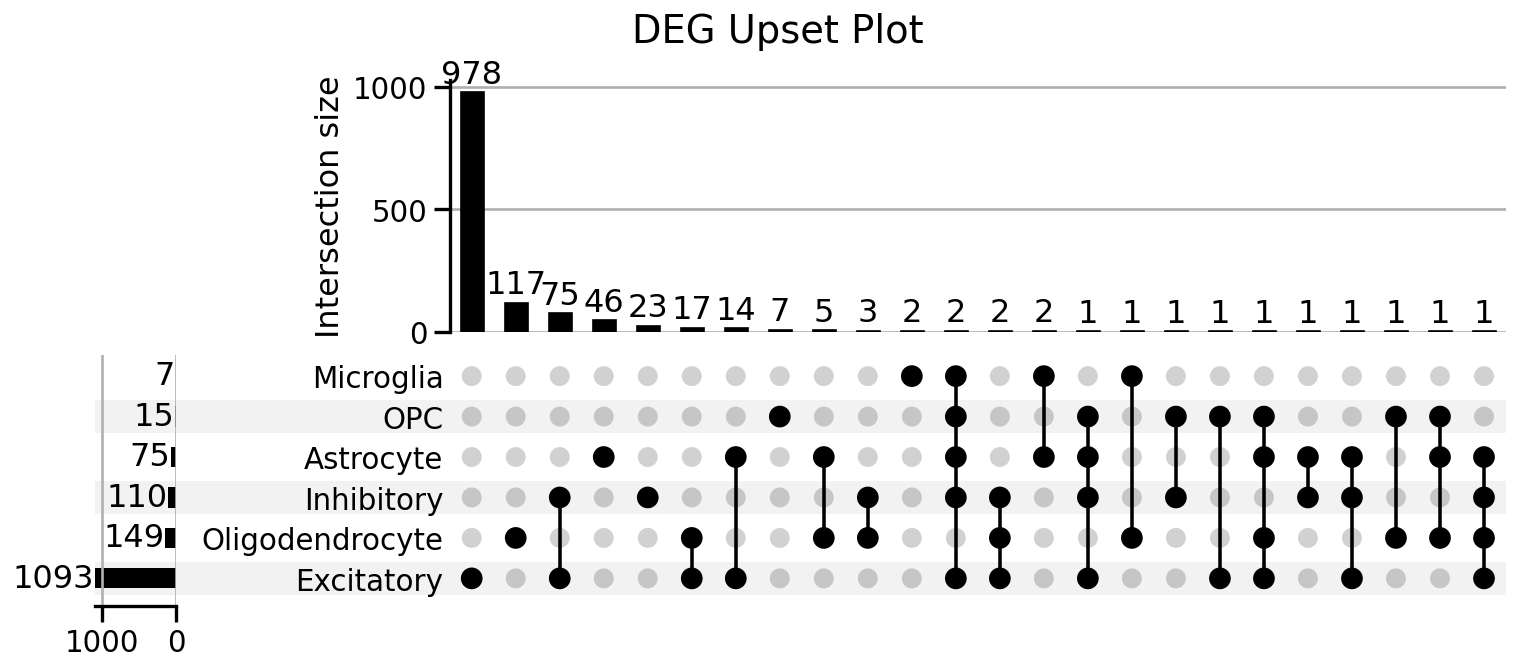

In [63]:
plot(upset_degs, show_counts=True, sort_by='cardinality')
plt.suptitle('DEG Upset Plot')
plt.savefig('../results/pathway_meta_analysis/DEG_Upset_plot.pdf')
plt.show()


### **Upset Plot from Mathys Data**

In [79]:
mathys_upset_dict = {}
for cell_type in ad_v_no_pat_score.celltype.unique():
    try:
        mathys_filt_degs = mathys_degs[cell_type][(mathys_degs[cell_type]['IndModel.adj.pvals'] < 0.01) &\
                                                  (abs(mathys_degs[cell_type]['IndModel.FC'] > 0.25))].index
        mathys_upset_dict[cell_type] = list(mathys_filt_degs)
    except KeyError:
        continue
    
mathys_upset_degs = from_contents(mathys_upset_dict)
mathys_upset_degs

/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/upsetplot/data.py:380: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pd.__version__) >= '0.23.0':
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


id
Excitatory Microglia Inhibitory Oligodendrocyte OPC   Astrocyte          
True       True      True       True            True  False      RASGEF1B
                                                      False        LINGO1
                                                      False       SLC26A3
           False     True       True            False False      MTRNR2L8
                                False           False False          DHFR
...                                                                   ...
False      False     False      False           False True          ITGB8
                                                      True          HVCN1
                                                      True       COLGALT2
                                                      True          RPL30
                                                      True           SYNM

[1172 rows x 1 columns]

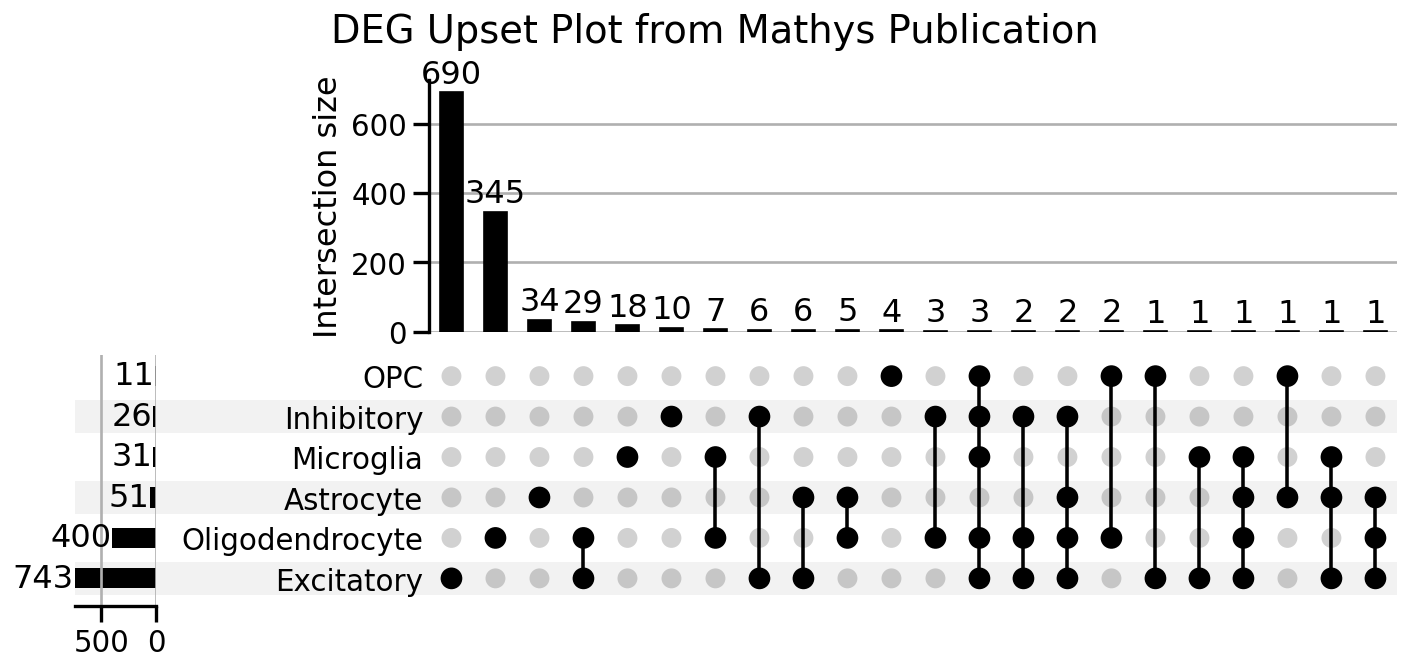

In [80]:
plot(mathys_upset_degs, show_counts=True, sort_by='cardinality')
plt.suptitle('DEG Upset Plot from Mathys Publication')
plt.savefig('../results/pathway_meta_analysis/DEG_Upset_plot_mathys.pdf')
plt.show()